# Toy Model of an EFT --- Mini-Project

### Alexandra Semposki

#### Started: 13 November 2020

In this project, we attempt to extract the coefficients of the Taylor expansion of an EFT model. Shown below is the original function in the theory:

$$
g(x) = \left(\frac{1}{2} + \tan \left(\frac{\pi x}{2} \right) \right)^{2}
$$

which possesses the Taylor expansion

$$
g(x) = 0.25 + 1.57x + 2.47x^{2} + 1.29x^{3} + \dots
$$

We will call the theory model for this situation as as the equation below:

$$
g_{th}(x) = \sum_{n=0}^{k} a_{n}x^{n}
$$

where $k$ represents the highest order we will go to in our polynomial fit. 

The first step is to generate some data from this model to use in our fitting process. This is done below. We need to remember that, when generating this synthetic data, we introduce a 5% error into each point, so that it looks more like the experimental data we'd be obtaining in the lab. This relation is given by (Eq. (2) in the paper):

$$
d_{j} = g(x_{j})(1+c\eta_{j})
$$

where $\eta$ is a normal distribution of mean 0 and standard deviation 1. $c$ is the relative error, 0.05 in this case. The error bars on each data point are constructed using

$$
\sigma_{j} = cd_{j}
$$

and are shown on the plot below.

<ErrorbarContainer object of 3 artists>

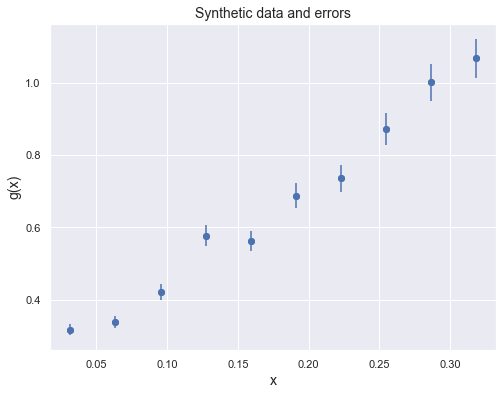

In [1]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

#My original sampled function is below
'''
#define the function we are extracting data from 
def model(x):
    return (0.5 + np.tan(np.pi*x/2))**2.0 

#define a step size for the x values 
h = (1.0/np.pi - 0.0)/10

#define the range of x values needed, excluding zero
x = np.arange(0.0 + h, 1.0/np.pi + h, h)

#generate the array of data for the initial values
data1 = model(x)

#introduce the 5% error 
rand = np.random.RandomState()
data = data1 + 0.05*rand.randn(10)

#calculate some error bars
sig = 0.05*data

'''

#Schindler-Phillips data set implemented below
x = 2.0/np.pi * np.array([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
data = np.array([0.31694, 0.33844, 0.42142, 0.57709, 0.56218, 0.68851, 0.73625, 0.87280, 1.0015, 1.0684])
sig = np.array([0.01585, 0.01692, 0.02107, 0.02885, 0.02811, 0.03443, 0.03681, 0.04364, 0.0501, 0.0534])

fig = plt.figure(figsize=(8,6))
plt.xlabel('x', fontsize = 14)
plt.ylabel('g(x)', fontsize = 14)
plt.title('Synthetic data and errors', fontsize = 14)
plt.plot(x, data, 'bo')
plt.errorbar(x, data, sig, fmt='o')

Now that this has been done, we need to start building the priors and the likelihood to go into Bayes' Theorem. Bayes' Theorem reads simply here as:

$$
pr(a|D,I) = \frac{pr(D|a,I) pr(a|I)}{pr(D|I)}
$$

where $a$ is the vector of Taylor expansion coefficients we are trying to model, and $D$ is the data we have from the "experiment" we've done above. $I$ is any prior information we have concerning this problem/experiment.

There are two priors we would like to test: uniform and Gaussian. These are below:

$$
pr(a|\bar{a},I) = 1 
$$
and
$$
pr(a|\bar{a},I) = \left(\frac{1}{\sqrt{2\pi}\bar{a}}\right)^{k+1} \exp\left(-\frac{a^{2}}{2\bar{a}^{2}}\right)
$$

where $\bar{a}$ is a parameter to be determined later, and referred to as 'afix' in the code.

The likelihood function is also needed for this project. It is given as:

$$
pr(D|a,I) = \prod_{j=1}^{N_{d}} \left(\frac{1}{\sqrt{2\pi} \sigma_{j,exp}}\right) \exp\left(-\frac{\chi^{2}}{2}\right)
$$

where the chi-squared term is given as

$$
\chi^{2} = \sum_{i=1}^{N_{d}} \left(\frac{d_{i} - g_{th}(x_{i})}{\sigma_{i}}\right)^{2}
$$

where $d_{i}$ is the data and $g_{th}(x_{i})$ is the prediction we get at $x_{i}$ from EFT using the polynomial expansion, and $\sigma_{i}$ are the errors we obtained previously.

Let's try to write these into functions we can call for the emcee sampler later on.

In [2]:
#introduce the uniform prior (log(1) = 0)
def log_uniform(a):
    
    if np.all(np.abs(a) < 1000):
        return 0
    
    else:
        return -np.inf 

#introduce the gaussian prior
def log_gaussprior(a, k):
    afix = 5.0
    pre = -(k + 1) * np.log(np.sqrt(2.0 * np.pi)*afix)
    return pre - np.dot(a,a)/(2.0*afix**2.0)

In [3]:
#define the model function
def g_model(a, x, k):

    g = 0.0
    
    for n in range(k+1):
        g += a[n] * (x**n)
        
    return g

#define the likelihood function (log likelihood for calculation efficiency)
def log_likelihood(a, x, data, sig, nd, k):
        
    #calculate the chi-squared
    chisq = 0.0 
    
    for i in range(nd):
        chisq += ((data[i] - g_model(a, x[i], k))/sig[i])**2.0
                
    #finish the function
    f = -0.5 * (np.sum(np.log(2.0 * np.pi * sig**2.0)) + chisq)
        
    return f

Now, after these definitions, we will need to define the posterior with the two different priors.

In [4]:
#define the log posteriors to be used
def log_posterior1(a, x, data, sig, nd, k):
    return log_uniform(a) + log_likelihood(a, x, data, sig, nd, k)

def log_posterior2(a, x, data, sig, nd, k):
    return log_gaussprior(a, k) + log_likelihood(a, x, data, sig, nd, k)

Once this is done, we can move on to setting up the emcee sampling procedure. 

In [5]:
#import the emcee sampler package
import emcee

#print the version we are using
print('emcee sampling (version: {})'.format(emcee.__version__))

#set up the number of parameters we are looking for
ndim = 4
nwalkers = 50 
nsteps = 20000#10000

#number of data points
nd = 10 

#order of the polynomial
k = 3

#dummy number to indicate real value
kreal = 3

print('Using {} walkers with {} steps each.'.format(nwalkers, nsteps))

#initialize the sequence by starting the walkers at a random point
starting_points = np.random.randn(nwalkers, ndim)

#set the sampler for the first posterior (uniform prior)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior1, args=[x, data, sig, nd, k])

#run the sampler and print the wall time
%time sampler.run_mcmc(starting_points, nsteps)
print('Calculation finished!')

emcee sampling (version: 3.0.2)
Using 50 walkers with 20000 steps each.
Wall time: 2min 50s
Calculation finished!


Now we need to take what this calculation produced and work with it until we can plot it. 

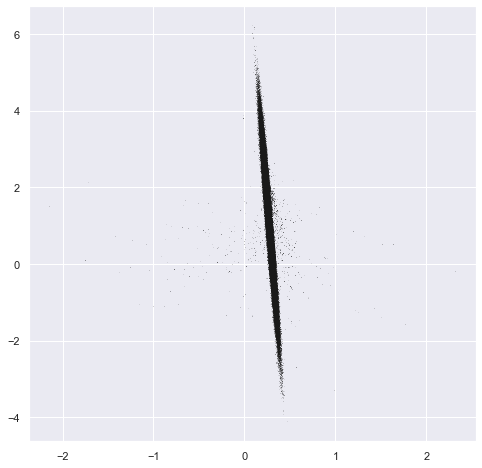

In [6]:
#take the individual walker chains and reshape them into one chain
emcee_trace = sampler.chain[:, :, :].reshape(-1, ndim).T

#plot the result
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(emcee_trace[0], emcee_trace[1], ',k', alpha=0.1);
#ax.hist(emcee_trace[0], bins=200, density=True)

As can be seen, this calculation is, at present, terrible. Let's try to remedy this with burn-in subtracted from the chain.

In [7]:
#create a burnin number of iterations
nburnin = 1000

#throw out the burn-in and reshape again
emcee_trace = sampler.chain[:, nburnin:, :].reshape(-1, ndim).T
emcee_lnprob = sampler.lnprobability[:, nburnin:].reshape(-1).T

Now we try and plot what we got. 

Max posterior is at: [0.203 2.553]


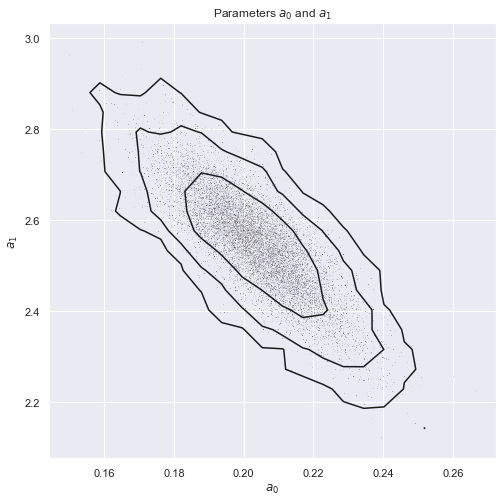

In [10]:
def compute_sigma_level(trace1, trace2, nbins=20):
    """From a set of traces, bin by number of standard deviations"""
    L, xbins, ybins = np.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1E-16
    logL = np.log(L)

    shape = L.shape
    L = L.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]
    
    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    return xbins, ybins, L_cumsum[i_unsort].reshape(shape)

def plot_MCMC_trace(ax, xdata, ydata, trace, scatter=False, **kwargs):
    """Plot traces and contours"""
    xbins, ybins, sigma = compute_sigma_level(trace[0], trace[1])
    ax.contour(xbins, ybins, sigma.T, levels=[0.683, 0.955, 0.997], **kwargs)
    if scatter:
        ax.plot(trace[0], trace[1], ',k', alpha=0.1)
        ax.set_title(r'Parameters $a_{0}$ and $a_{1}$')
        ax.set_xlabel(r'$a_{0}$')
        ax.set_ylabel(r'$a_{1}$')
    
# Convenience function to extract the peak position of the mode
def max_of_mode(sampler_object):
    max_arg = np.argmax(sampler.flatlnprobability)
    return(sampler.flatchain[max_arg])
    
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
plot_MCMC_trace(ax, x, data, emcee_trace, scatter=True,colors='k');
max_mode_a=max_of_mode(sampler)
with np.printoptions(precision=3):
    print(f'Max posterior is at: {max_mode_a}')

Now that this is working for two parameters, we can try the corner plot package. Even if we set ndim and k to higher orders, we will be able to only plot the first two values in the contour above, while plotting all parameters using corner. 

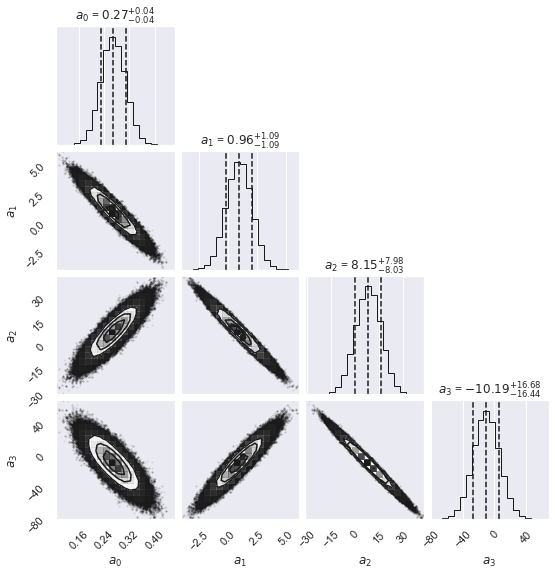

In [9]:
import corner

#use the emcee_trace parameter
fig, ax = plt.subplots(4,4, figsize=(8,8))
corner.corner(emcee_trace.T,labels=[r"$a_{0}$", r"$a_{1}$", r"$a_{2}$", r"$a_{3}$", r"$a_{4}$", r"$a_{5}$", r"$a_{6}$"], quantiles=[0.16, 0.5, 0.84],fig=fig,show_titles=True);

Given this information, we print out the chi-squared per degree of freedom below.

In [10]:
#set up a chi-squared/dof calculation using the original table I calculated
a0 = [0.475]
a1 = [0.20, 2.56]
a2 = [0.25, 1.57, 3.32]
a3 = [0.27, 0.98, 7.95, -9.82]
a4 = [0.327, -1.624, 41.497, -167.795, 242.527]
a5 = [3.667e-01, -3.687e+00, 7.476e+01, -4.001e+02, 9.749e+02, -8.535e+02]
a6 = [3.605e-01, -3.453e+00, 7.223e+01, -3.790e+02, 8.104e+02, -1.918e+02, -9.256e+02]

#initialise all variables
chisq0 = 0.0
chisq1 = 0.0
chisq2 = 0.0
chisq3 = 0.0
chisq4 = 0.0
chisq5 = 0.0
chisq6 = 0.0

#call the g_model function to use with the above values
for i in range(nd):
    chisq0 += ((data[i] - g_model(a0, x[i], 0))/sig[i])**2.0
    chisq1 += ((data[i] - g_model(a1, x[i], 1))/sig[i])**2.0
    chisq2 += ((data[i] - g_model(a2, x[i], 2))/sig[i])**2.0
    chisq3 += ((data[i] - g_model(a3, x[i], 3))/sig[i])**2.0
    chisq4 += ((data[i] - g_model(a4, x[i], 4))/sig[i])**2.0
    chisq5 += ((data[i] - g_model(a5, x[i], 5))/sig[i])**2.0
    chisq6 += ((data[i] - g_model(a6, x[i], 6))/sig[i])**2.0

#define the dof for each case above (data points - parameters)
dof0 = 9
dof1 = 8
dof2 = 7
dof3 = 6
dof4 = 5
dof5 = 4
dof6 = 3 

#calculate the chisq/dof for each case
chidof0 = chisq0/dof0
chidof1 = chisq1/dof1
chidof2 = chisq2/dof2
chidof3 = chisq3/dof3
chidof4 = chisq4/dof4
chidof5 = chisq5/dof5
chidof6 = chisq6/dof6

#print the above results
print("---Chi-squared/dof results---\n k_max = 0: {}\n k_max = 1: {}\n k_max = 2: {}".format(chidof0, chidof1, chidof2))
print(" k_max = 3: {}\n k_max = 4: {}\n k_max = 5: {}\n k_max = 6: {}\n".format(chidof3, chidof4, chidof5, chidof6))

---Chi-squared/dof results---
 k_max = 0: 66.55943153886398
 k_max = 1: 2.247490494161892
 k_max = 2: 1.6419241822173756
 k_max = 3: 1.8569813282593823
 k_max = 4: 1.9592390841506195
 k_max = 5: 2.2229756075167226
 k_max = 6: 2.850372668088113



Next step would be to repeat this calculation for the Gaussian prior. We'll do this below, as we don't want to overwrite our results from the uniform prior. 

In [5]:
#import the emcee sampler package
import emcee

#print the version we are using
print('emcee sampling (version: {})'.format(emcee.__version__))

#set up the number of parameters we are looking for
ndim = 2 #4
nwalkers = 50 
nsteps = 500 #10000 

#number of data points
nd = 10 

#order of the polynomial
k = 1

#dummy number to indicate real value
kreal = 1

print('Using {} walkers with {} steps each.'.format(nwalkers, nsteps))

#initialize the sequence by starting the walkers at a random point
starting_points = np.random.randn(nwalkers, ndim)

#set the sampler for the second posterior (Gaussian prior)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior2, args=[x, data, sig, nd, k])

#run the sampler and print the wall time
%time sampler.run_mcmc(starting_points, nsteps)
print('Calculation finished!')

emcee sampling (version: 3.0.2)
Using 50 walkers with 500 steps each.
Wall time: 1.88 s
Calculation finished!


Now we reshape the chains and plot the first two coefficients to check them.

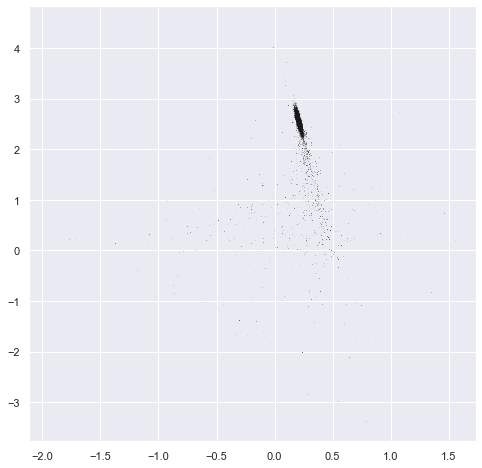

In [6]:
#take the individual walker chains and reshape them into one chain
emcee_trace = sampler.chain[:, :, :].reshape(-1, ndim).T

#plot the result
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(emcee_trace[0], emcee_trace[1], ',k', alpha=0.1);

From here, we cut a number of burn-in iterations from the chains and plot the rest.

In [8]:
#create a burnin number of iterations
nburnin = 100#1000

#throw out the burn-in and reshape again
emcee_trace = sampler.chain[:, nburnin:, :].reshape(-1, ndim).T
emcee_lnprob = sampler.lnprobability[:, nburnin:].reshape(-1).T

Max posterior is at: [0.203 2.553]


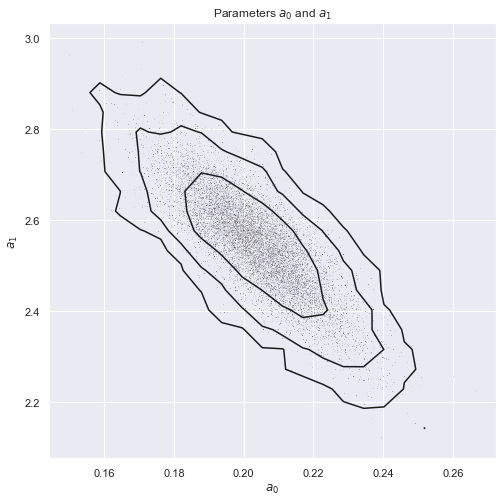

In [11]:
#plot the results using the functions from the uniform prior section
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
plot_MCMC_trace(ax, x, data, emcee_trace, scatter=True,colors='k');
max_mode_a=max_of_mode(sampler)
with np.printoptions(precision=3):
    print(f'Max posterior is at: {max_mode_a}')

Following this, we plot the contours for each coefficient using corner. 

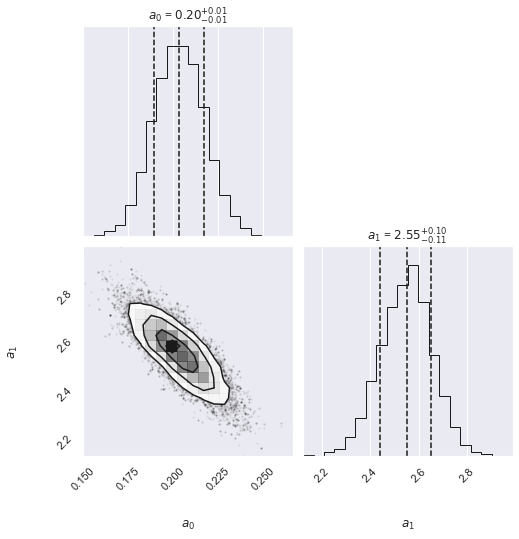

In [13]:
import corner

#use the emcee_trace parameter
fig, ax = plt.subplots(2,2, figsize=(8,8))
corner.corner(emcee_trace.T,labels=[r"$a_{0}$", r"$a_{1}$", r"$a_{2}$", r"$a_{3}$", r"$a_{4}$", r"$a_{5}$", r"$a_{6}$"], quantiles=[0.16, 0.5, 0.84],fig=fig,show_titles=True);

Comparing the values obtained from the Gaussian prior + likelihood above, it is evident that they match well enough with the paper to be considered sufficiently accurate. 

## Adding the Savage-Dickey Density Ratio calculation

#### Started: 20 April 2021

In order to determine the usefulness of extra parameters and test our confidence in our model that we have computed with an MH sampler, we want to use the Savage-Dickey density ratio (SDDR) to easily determine this. The equation is simple and stated below:

$$
B_{01} = \frac{p(\omega|d, M_{1})}{\pi(\omega|M_{1})}|_{\omega = \omega_{*}},
$$

where the numerator is the normalized posterior and the denominator is the prior.

In order to do this, we will pull results from our previous calculation and see what we get for $B_{01}$, also known as the Bayes factor.

***Game plan for this code***

We need the elements listed below for this to work:

- Control over binning in corner plot (set the bins to a specific width so we know we don't have too much spread over the distribution)
    - This can be done using something like the bins option, which sets the number of bins, or the option hist_bin_factor which seems to multiply the bins by a specific number so you could get more of them. I don't see a width yet that I can set.
- Sampling run over the prior for the selected number of coefficents alone, for the exact same number of samples as we did for the posterior
- Division of those two quantities